# Interaction Distributions
Based on code in R68_gdirect_first_spectra
Plot spatial distributions of different interaction types in the CDMS detector

In [1]:
import numpy as np
import pandas as pd
import sima2py as sapy
import re

## Simulation Data Skims

We'll use several skims of the full simulation data with cuts to select different interactions. The sims are done with commands like

```./sima2py.py --regex 'Run68_gdirect_bknd_R68_PuBe_0x0006_10M_1550\S+.txt' --filedir /data/chocula/villaa/k100Sim_Data/captureCal/ --outfile /data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_cap.h5 --cuts NRc```

We'll use the following files, all located in `/data/chocula/villaa/k100Sim_Data/captureCalhdf5/`:

| File                                          | Description  |
| :---                                          |    :---:     |
| `R68_gdirect_testskim_superhighstat.h5`       | NR only      |
| `R68_gdirect_testskim_superhighstat_nocap.h5` | No capture   |
| `R68_gdirect_testskim_superhighstat_nocap_er_lowe.h5` | ER, No capture   |
| `R68_gdirect_testskim_superhighstat_nr_wcap.h5`   | NR in events having capture |
| `R68_gdirect_testskim_superhighstat_cap.h5`   | n-captures (nCap==1). Includes (n,p) |
| `R68_gdirect_testskim_superhighstat_wcap.h5`   | events having an 'nCap==1' hit |
| `R68_gdirect_testskim_stupidhighstat_wcap.h`   | events having an 'nCap==1' hit, 10x stats |

Actually, the last 4 files are in `/home/mast/cdms/analysis/run068/simulations/k100_ncapture_cal/data` for now due to permissions issues.

In [2]:
#play around with some hits data stored in h5 file
#===============to suppress h5py warning see:
#https://github.com/h5py/h5py/issues/961
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()

f_nr = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat.h5","r")
data_nr = f_nr['geant4/hits']

f_nocap = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap.h5","r")
data_nocap = f_nocap['geant4/hits']

f_nocap_er = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap_er_lowe.h5","r")
data_nocap_er = f_nocap_er['geant4/hits']

f_nr_wcap = h5py.File("/home/mast/cdms/analysis/run068/simulations/k100_ncapture_cal/data/R68_gdirect_testskim_superhighstat_nr_wcap.h5","r")
data_nr_wcap = f_nr_wcap['geant4/hits']

f_cap = h5py.File("/home/mast/cdms/analysis/run068/simulations/k100_ncapture_cal/data/R68_gdirect_testskim_superhighstat_cap.h5","r")
data_cap = f_cap['geant4/hits']

f_wcap = h5py.File("/home/mast/cdms/analysis/run068/simulations/k100_ncapture_cal/data/R68_gdirect_testskim_stupidhighstat_wcap.h5","r")
data_wcap = f_wcap['geant4/hits']

print(np.shape(data_nocap_er))

(29492, 22)


In [14]:
#now make a dataframe with the restricted data
#Columns are:
cols=['EV', 'DT', 'TS', 'P', 'Type', 'E1', 'D3', 'PX3', 'PY3', 'PZ3', 'X3', 'Y3', 'Z3',
      'time3', 'PX1', 'PY1', 'PZ1', 'X1', 'Y1', 'Z1', 'time1', 'nCap']

sel_names=['EV', 'Type', 'E1', 'D3', 'X3', 'Y3', 'Z3', 'PX1', 'PY1', 'PZ1', 'nCap']#Select these variables
sel=[cols.index(i) for i in sel_names]

nr_data = data_nr[:,sel]
nr_dataframe = pd.DataFrame(data=nr_data, columns=sel_names)
nr_data_nocap = data_nocap[:,sel]
nr_dataframe_nocap = pd.DataFrame(data=nr_data_nocap, columns=sel_names)
er_data_nocap = data_nocap_er[:,sel]
er_dataframe_nocap = pd.DataFrame(data=er_data_nocap, columns=sel_names)
nr_data_wcap = data_nr_wcap[:,sel]
nr_dataframe_wcap = pd.DataFrame(data=nr_data_wcap, columns=sel_names)
cap_data = data_cap[:,sel]
cap_dataframe = pd.DataFrame(data=cap_data, columns=sel_names)
wcap_data = data_wcap[:,sel]
wcap_dataframe = pd.DataFrame(data=wcap_data, columns=sel_names)

#need unique event numbers to combat rare, duplicate 'EV's
nr_evnew=np.cumsum(np.diff(nr_data[:,0],prepend=nr_data[0,0]).astype(bool).astype(float))
nr_dataframe.insert(0,'EVnew',nr_evnew)

nr_nocap_evnew=np.cumsum(np.diff(nr_data_nocap[:,0],prepend=nr_data_nocap[0,0]).astype(bool).astype(float))
nr_dataframe_nocap.insert(0,'EVnew',nr_nocap_evnew)

er_nocap_evnew=np.cumsum(np.diff(er_data_nocap[:,0],prepend=er_data_nocap[0,0]).astype(bool).astype(float))
er_dataframe_nocap.insert(0,'EVnew',er_nocap_evnew)

nr_wcap_evnew=np.cumsum(np.diff(nr_data_wcap[:,0],prepend=nr_data_wcap[0,0]).astype(bool).astype(float))
nr_dataframe_wcap.insert(0,'EVnew',nr_wcap_evnew)

cap_evnew=np.cumsum(np.diff(cap_data[:,0],prepend=cap_data[0,0]).astype(bool).astype(float))
cap_dataframe.insert(0,'EVnew',cap_evnew)

wcap_evnew=np.cumsum(np.diff(wcap_data[:,0],prepend=wcap_data[0,0]).astype(bool).astype(float))
wcap_dataframe.insert(0,'EVnew',wcap_evnew)

#print(nr_dataframe)

In [38]:
##Group hits into vectors for each thrown event

groupbyvec=['EVnew']

#NR only
max_vec_nr = np.max(nr_dataframe.groupby(groupbyvec,axis=0).size())
vec0_nr = np.zeros((1,max_vec_nr))

evec_nr = np.zeros((0,max_vec_nr))
xvec_nr = np.zeros((0,max_vec_nr))
yvec_nr = np.zeros((0,max_vec_nr))
zvec_nr = np.zeros((0,max_vec_nr))
nhit_nr = np.zeros((0,1))

nr_grouped=nr_dataframe.groupby(groupbyvec).agg({'D3':list,'X3':list,'Y3':list,'Z3':list})
for d3,x1,y1,z1 in zip(nr_grouped.D3,nr_grouped.X3,nr_grouped.Y3,nr_grouped.Z3):
    d3i=vec0_nr.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_nr = np.append(evec_nr,d3i*1e6,0) #convert from MeV
    
    x1i=vec0_nr.copy()
    x1i[0,0:np.shape(x1)[0]] = np.transpose(np.asarray(x1))
    xvec_nr = np.append(xvec_nr,x1i,0)
    y1i=vec0_nr.copy()
    y1i[0,0:np.shape(y1)[0]] = np.transpose(np.asarray(y1))
    yvec_nr = np.append(yvec_nr,y1i,0)    
    z1i=vec0_nr.copy()
    z1i[0,0:np.shape(z1)[0]] = np.transpose(np.asarray(z1))
    zvec_nr = np.append(zvec_nr,z1i,0)
    
    nhit_nr = np.append(nhit_nr,np.shape(d3)[0])
    
#NR no cap
max_vec_nr_nocap = np.max(nr_dataframe_nocap.groupby(groupbyvec,axis=0).size())
vec0_nr_nocap = np.zeros((1,max_vec_nr_nocap))

evec_nr_nocap = np.zeros((0,max_vec_nr_nocap))
xvec_nr_nocap = np.zeros((0,max_vec_nr_nocap))
yvec_nr_nocap = np.zeros((0,max_vec_nr_nocap))
zvec_nr_nocap = np.zeros((0,max_vec_nr_nocap))
nhit_nr_nocap = np.zeros((0,1))

nr_nocap_grouped=nr_dataframe_nocap.groupby(groupbyvec).agg({'D3':list,'X3':list,'Y3':list,'Z3':list})
for d3,x1,y1,z1 in zip(nr_nocap_grouped.D3,nr_nocap_grouped.X3,nr_nocap_grouped.Y3,nr_nocap_grouped.Z3):
    d3i=vec0_nr_nocap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_nr_nocap = np.append(evec_nr_nocap,d3i*1e6,0) #convert from MeV
    
    x1i=vec0_nr_nocap.copy()
    x1i[0,0:np.shape(x1)[0]] = np.transpose(np.asarray(x1))
    xvec_nr_nocap = np.append(xvec_nr_nocap,x1i,0)
    y1i=vec0_nr_nocap.copy()
    y1i[0,0:np.shape(y1)[0]] = np.transpose(np.asarray(y1))
    yvec_nr_nocap = np.append(yvec_nr_nocap,y1i,0)    
    z1i=vec0_nr_nocap.copy()
    z1i[0,0:np.shape(z1)[0]] = np.transpose(np.asarray(z1))
    zvec_nr_nocap = np.append(zvec_nr_nocap,z1i,0)
    
    nhit_nr_nocap = np.append(nhit_nr_nocap,np.shape(d3)[0])
    
    
#NR w/cap
max_vec_nr_wcap = np.max(nr_dataframe_wcap.groupby(groupbyvec,axis=0).size())
vec0_nr_wcap = np.zeros((1,max_vec_nr_wcap))

evec_nr_wcap = np.zeros((0,max_vec_nr_wcap))
xvec_nr_wcap = np.zeros((0,max_vec_nr_wcap))
yvec_nr_wcap = np.zeros((0,max_vec_nr_wcap))
zvec_nr_wcap = np.zeros((0,max_vec_nr_wcap))
nhit_nr_wcap = np.zeros((0,1))

nr_wcap_grouped=nr_dataframe_wcap.groupby(groupbyvec).agg({'D3':list,'X3':list,'Y3':list,'Z3':list})
for d3,x1,y1,z1 in zip(nr_wcap_grouped.D3,nr_wcap_grouped.X3,nr_wcap_grouped.Y3,nr_wcap_grouped.Z3):
    d3i=vec0_nr_wcap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_nr_wcap = np.append(evec_nr_wcap,d3i*1e6,0) #convert from MeV
    
    x1i=vec0_nr_wcap.copy()
    x1i[0,0:np.shape(x1)[0]] = np.transpose(np.asarray(x1))
    xvec_nr_wcap = np.append(xvec_nr_wcap,x1i,0)
    y1i=vec0_nr_wcap.copy()
    y1i[0,0:np.shape(y1)[0]] = np.transpose(np.asarray(y1))
    yvec_nr_wcap = np.append(yvec_nr_wcap,y1i,0)    
    z1i=vec0_nr_wcap.copy()
    z1i[0,0:np.shape(z1)[0]] = np.transpose(np.asarray(z1))
    zvec_nr_wcap = np.append(zvec_nr_wcap,z1i,0)
    
    nhit_nr_wcap = np.append(nhit_nr_wcap,np.shape(d3)[0])

    
#ER
max_vec_er_nocap = np.max(er_dataframe_nocap.groupby(groupbyvec,axis=0).size())
vec0_er_nocap = np.zeros((1,max_vec_er_nocap))

evec_er_nocap = np.zeros((0,max_vec_er_nocap))
xvec_er_nocap = np.zeros((0,max_vec_er_nocap))
yvec_er_nocap = np.zeros((0,max_vec_er_nocap))
zvec_er_nocap = np.zeros((0,max_vec_er_nocap))
nhit_er_nocap = np.zeros((0,1))

er_nocap_grouped=er_dataframe_nocap.groupby(groupbyvec).agg({'D3':list,'X3':list,'Y3':list,'Z3':list})
for d3,x1,y1,z1 in zip(er_nocap_grouped.D3,er_nocap_grouped.X3,er_nocap_grouped.Y3,er_nocap_grouped.Z3):
    d3i=vec0_er_nocap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_er_nocap = np.append(evec_er_nocap,d3i*1e6,0) #convert from MeV
    
    x1i=vec0_er_nocap.copy()
    x1i[0,0:np.shape(x1)[0]] = np.transpose(np.asarray(x1))
    xvec_er_nocap = np.append(xvec_er_nocap,x1i,0)
    y1i=vec0_er_nocap.copy()
    y1i[0,0:np.shape(y1)[0]] = np.transpose(np.asarray(y1))
    yvec_er_nocap = np.append(yvec_er_nocap,y1i,0)    
    z1i=vec0_er_nocap.copy()
    z1i[0,0:np.shape(z1)[0]] = np.transpose(np.asarray(z1))
    zvec_er_nocap = np.append(zvec_er_nocap,z1i,0)
    
    nhit_er_nocap = np.append(nhit_er_nocap,np.shape(d3)[0])
    
    
#Captures
max_vec_cap = np.max(cap_dataframe.groupby(groupbyvec,axis=0).size())
vec0_cap = np.zeros((1,max_vec_cap))

evec_cap = np.zeros((0,max_vec_cap))
xvec_cap = np.zeros((0,max_vec_cap))
yvec_cap = np.zeros((0,max_vec_cap))
zvec_cap = np.zeros((0,max_vec_cap))
nhit_cap = np.zeros((0,1))

cap_grouped=cap_dataframe.groupby(groupbyvec).agg({'D3':list,'X3':list,'Y3':list,'Z3':list})
for d3,x1,y1,z1 in zip(cap_grouped.D3,cap_grouped.X3,cap_grouped.Y3,cap_grouped.Z3):
    d3i=vec0_cap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_cap = np.append(evec_cap,d3i*1e6,0) #convert from MeV
    
    x1i=vec0_cap.copy()
    x1i[0,0:np.shape(x1)[0]] = np.transpose(np.asarray(x1))
    xvec_cap = np.append(xvec_cap,x1i,0)
    y1i=vec0_cap.copy()
    y1i[0,0:np.shape(y1)[0]] = np.transpose(np.asarray(y1))
    yvec_cap = np.append(yvec_cap,y1i,0)    
    z1i=vec0_cap.copy()
    z1i[0,0:np.shape(z1)[0]] = np.transpose(np.asarray(z1))
    zvec_cap = np.append(zvec_cap,z1i,0)
    
    nhit_cap = np.append(nhit_cap,np.shape(d3)[0])

In [39]:
#with Captures
#This takes a little more post-processing to remove (n,p) interactions which get mis-tagged with nCap==1
max_vec_wcap = np.max(wcap_dataframe[wcap_dataframe['nCap']==1].groupby(groupbyvec).size())
vec0_wcap = np.zeros((1,max_vec_wcap))

e1vec_wcap = np.zeros((0,max_vec_wcap))
xvec_wcap = np.zeros((0,max_vec_wcap))
yvec_wcap = np.zeros((0,max_vec_wcap))
zvec_wcap = np.zeros((0,max_vec_wcap))
nhit_wcap = np.zeros((0,1))

wcap_grouped=wcap_dataframe.groupby(groupbyvec).agg({'Type':list,'nCap':list,'E1':list,'X3':list,'Y3':list,'Z3':list})
for Type,nCap,e1,x3,y3,z3 in zip(wcap_grouped.Type,wcap_grouped.nCap,wcap_grouped.E1,wcap_grouped.X3,wcap_grouped.Y3,wcap_grouped.Z3):
    TypeArr=np.asarray(Type)
    #Reject any event that has a nucleus (Type>3000) other than Si (Type==**014)
    cNotSi=(TypeArr>3000) & (TypeArr%100!=14)
    if np.any(cNotSi):
        continue
    
    #mask to save only the capturing step
    cNcap=np.asarray(nCap)==1
    
    e1i=vec0_wcap.copy()
    e1i[0,0:np.shape(e1)[0]] = np.transpose(np.asarray(e1)[cNcap])
    e1vec_wcap = np.append(e1vec_wcap,e1i*1e6,0) #convert from MeV
    
    x3i=vec0_wcap.copy()
    x3i[0,0:np.shape(x3)[0]] = np.transpose(np.asarray(x3)[cNcap])
    xvec_wcap = np.append(xvec_wcap,x3i,0)
    y3i=vec0_wcap.copy()
    y3i[0,0:np.shape(y3)[0]] = np.transpose(np.asarray(y3)[cNcap])
    yvec_wcap = np.append(yvec_wcap,y3i,0)    
    z3i=vec0_wcap.copy()
    z3i[0,0:np.shape(z3)[0]] = np.transpose(np.asarray(z3)[cNcap])
    zvec_wcap = np.append(zvec_wcap,z3i,0)
    
    nhit_wcap = np.append(nhit_wcap,np.shape(np.asarray(e1)[cNcap])[0])

In [40]:
np.max(wcap_dataframe[wcap_dataframe['nCap']==1].groupby(['EVnew']).size())

1

In [41]:
wcap_dataframe[wcap_dataframe['EV']==4637291.0]

,EVnew,EV,Type,E1,D3,X3,Y3,Z3,PX1,PY1,PZ1,nCap
38739,3406.0,4637291.0,2112.0,2.441789e-08,0.000000,24.522107,25.728692,38.747101,0.000040,0.004252,0.005273,1.0
38740,3406.0,4637291.0,29014.0,5.187821e-04,0.000519,24.522107,25.728692,38.747101,-0.958841,5.108731,-0.989657,0.0
38741,3406.0,4637291.0,29014.0,0.000000e+00,0.000000,24.522107,25.728692,38.747101,-0.000000,0.000000,-0.000000,0.0
38742,3406.0,4637291.0,22.0,3.539001e+00,0.000000,19.204382,-46.164832,37.674071,-0.261026,-3.528969,-0.052671,0.0
38743,3406.0,4637291.0,22.0,3.539003e+00,0.000000,20.097416,25.344515,31.820318,-1.903053,-0.165234,-2.979199,0.0
38744,3406.0,4637291.0,22.0,3.778897e-01,0.000000,1.798182,25.989036,49.812081,-0.269378,0.009488,0.264851,0.0
38745,3406.0,4637291.0,22.0,2.761057e-01,0.000000,1.678394,29.970860,53.368999,-0.006193,0.205862,0.183894,0.0
38746,3406.0,4637291.0,11.0,1.017839e-01,0.101784,1.777505,25.973608,49.818442,-0.263185,-0.196374,0.080957,0.0
38747,3406.0,4637291.0,11.0,3.161113e+00,1.057353,18.908923,25.217406,29.460285,-1.633676,-0.174722,-3.244050,0.0
38748,3406.0,4637291.0,11.0,2.103760e+00,0.037664,18.774581,25.194586,29.433735,-2.481465,-0.421514,-0.490413,0.0


In [42]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()
damic_yv = np.vectorize(damic_y) #vectorize it

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [43]:
print(damic_y(2000))

0.1595234066959043


In [44]:
#convert evec to eVee
V = 120
eps = 3.8 #eV for silicon
F = 0.1161 #silicon value taken from https://www.sciencedirect.com/science/article/pii/S0168900297009650

evec_nr_ee = (evec_nr + evec_nr*damic_y(evec_nr)*(V/eps))/(1+(V/eps))
evec_nr_nocap_ee = (evec_nr_nocap + evec_nr_nocap*damic_y(evec_nr_nocap)*(V/eps))/(1+(V/eps))
evec_er_nocap_ee = (evec_er_nocap + evec_er_nocap*(V/eps))/(1+(V/eps))
evec_nr_wcap_ee = (evec_nr_wcap + evec_nr_wcap*damic_y(evec_nr_wcap)*(V/eps))/(1+(V/eps))

evec_cap_ee = (evec_cap + evec_cap*(V/eps))/(1+(V/eps))

In [45]:
#distributions for uniform volume distribution in cylinder
def unifxdist(x,N,R):
    A=N/(np.pi*R**2)
    return A*2*(R**2-x**2)**0.5
def unifzdist(z,N,Zmin,Zmax):
    return N/(Zmax-Zmin)*(z>Zmin)*(z<Zmax)

R=50
Z=33
Zmin=20
Zmax=Zmin+Z
Z0=Zmin+Z/2

Nr=50
dr=2*R/Nr
rbins=np.linspace(-R,R,Nr)
rs=np.linspace(-R,R,100)

Nz=50
dz=Z/Nz
zbins=np.linspace(-Z/2,Z/2,Nz)
zs=np.linspace(-Z/2,Z/2,100)

#Get energy-weighted positions
xavg_nr = np.sum(evec_nr*xvec_nr,1)/np.sum(evec_nr,1)
yavg_nr = np.sum(evec_nr*yvec_nr,1)/np.sum(evec_nr,1)
zavg_nr = np.sum(evec_nr*zvec_nr,1)/np.sum(evec_nr,1)

xfirst_nr = np.array([xi[0] for xi in xvec_nr])
yfirst_nr = np.array([yi[0] for yi in yvec_nr])
zfirst_nr = np.array([zi[0] for zi in zvec_nr])

xavg_nr_wcap = np.sum(evec_nr_wcap*xvec_nr_wcap,1)/np.sum(evec_nr_wcap,1)
yavg_nr_wcap = np.sum(evec_nr_wcap*yvec_nr_wcap,1)/np.sum(evec_nr_wcap,1)
zavg_nr_wcap = np.sum(evec_nr_wcap*zvec_nr_wcap,1)/np.sum(evec_nr_wcap,1)

#Capture events have a single, 0-energy hit
xavg_cap = xvec_cap
yavg_cap = yvec_cap
zavg_cap = zvec_cap

#Capture events have 1 0-energy hits
xavg_wcap = xvec_wcap
yavg_wcap = yvec_wcap
zavg_wcap = zvec_wcap

In [46]:
xvec_wcap

array([[ 24.91854658],
       [-22.00954725],
       [-45.31283163],
       ...,
       [ 11.68104406],
       [ 34.69034129],
       [-38.12186123]])

In [47]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
savePlots=False

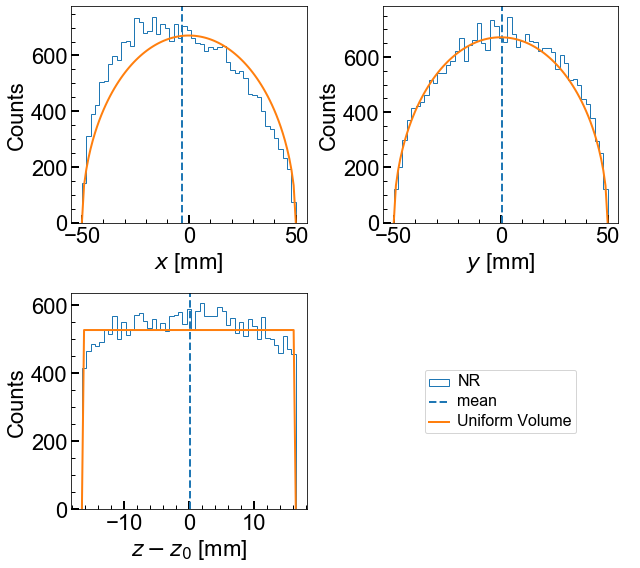

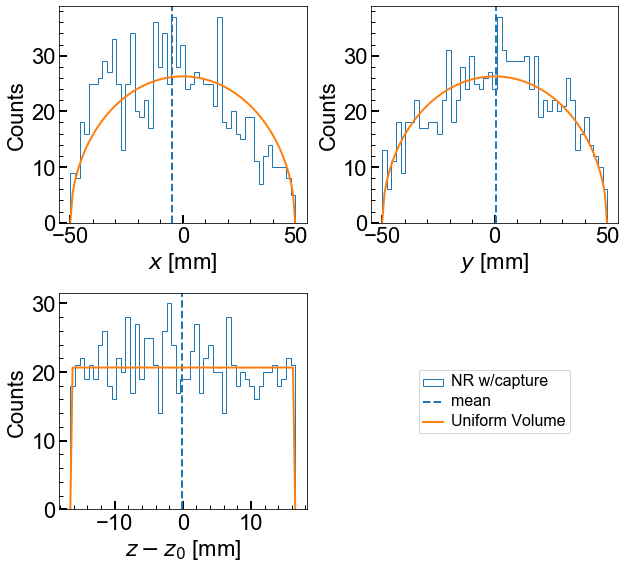

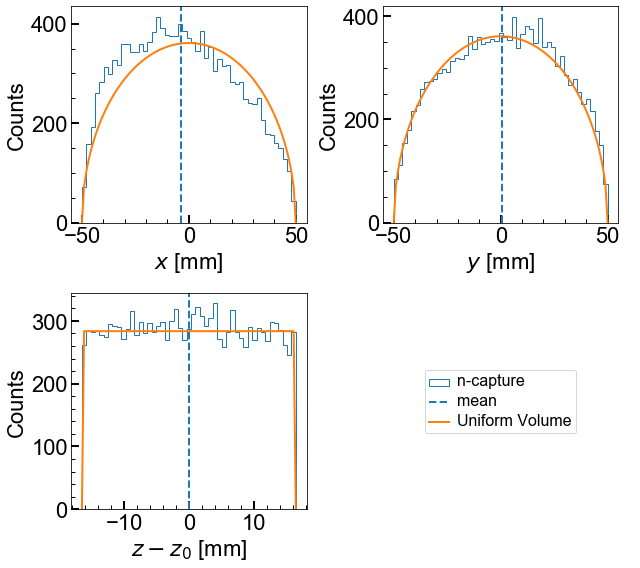

In [62]:
##Plot spatial distributions

######
#NR events
fig,axes = plt.subplots(2,2,figsize=(9.0,8.0),sharex=False)
_,_,a_nr = axes[0,0].hist(xavg_nr,bins=rbins,histtype='step',label='NR')
b=axes[0,0].axvline(np.mean(xavg_nr),ls='--',label='mean')
c, = axes[0,0].plot(rs,dr*unifxdist(rs,len(xavg_nr),R),label='Uniform Volume')
axes[0,0].set_xlabel(r'$x$ [mm]')
axes[0,0].set_ylabel('Counts')

axes[0,1].hist(yavg_nr,bins=rbins, histtype='step')
axes[0,1].axvline(np.mean(yavg_nr), ls='--')
axes[0,1].plot(rs,dr*unifxdist(rs,len(xavg_nr),R))
axes[0,1].set_xlabel(r'$y$ [mm]')
axes[0,1].set_ylabel('Counts')

axes[1,0].hist(zavg_nr-Z0,bins=zbins, histtype='step')
axes[1,0].axvline(np.mean(zavg_nr-Z0), ls='--')
axes[1,0].plot(zs,dz*unifzdist(zs,len(xavg_nr),-Z/2,+Z/2))
axes[1,0].set_xlabel(r'$z - z_0$ [mm]')
axes[1,0].set_ylabel('Counts')

axes[1,1].axis('off')
p=[a_nr[0],b,c]
axes[1,1].legend(p, [pi.get_label() for pi in p],loc='center')
plt.setp(axes[1,1].get_legend().get_texts(), fontsize='16')

'''
#Some settings Anthony used
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
'''

plt.tight_layout()
if savePlots:
    plt.savefig('figures/R68_sim_gdirect_dist_nr.png')
plt.show()


######
#NR wcap events
fig,axes = plt.subplots(2,2,figsize=(9.0,8.0),sharex=False)
_,_,a_nr = axes[0,0].hist(xavg_nr_wcap,bins=rbins,histtype='step',label='NR w/capture')
b=axes[0,0].axvline(np.mean(xavg_nr_wcap),ls='--',label='mean')
c, = axes[0,0].plot(rs,dr*unifxdist(rs,len(xavg_nr_wcap),R),label='Uniform Volume')
axes[0,0].set_xlabel(r'$x$ [mm]')
axes[0,0].set_ylabel('Counts')

axes[0,1].hist(yavg_nr_wcap,bins=rbins, histtype='step')
axes[0,1].axvline(np.mean(yavg_nr_wcap), ls='--')
axes[0,1].plot(rs,dr*unifxdist(rs,len(xavg_nr_wcap),R))
axes[0,1].set_xlabel(r'$y$ [mm]')
axes[0,1].set_ylabel('Counts')

axes[1,0].hist(zavg_nr_wcap-Z0,bins=zbins, histtype='step')
axes[1,0].axvline(np.mean(zavg_nr_wcap-Z0), ls='--')
axes[1,0].plot(zs,dz*unifzdist(zs,len(xavg_nr_wcap),-Z/2,+Z/2))
axes[1,0].set_xlabel(r'$z - z_0$ [mm]')
axes[1,0].set_ylabel('Counts')

axes[1,1].axis('off')
p=[a_nr[0],b,c]
axes[1,1].legend(p, [pi.get_label() for pi in p],loc='center')
plt.setp(axes[1,1].get_legend().get_texts(), fontsize='16')

plt.tight_layout()
if savePlots:
    plt.savefig('figures/R68_sim_gdirect_dist_nr_wcap.png')
plt.show()

######
#Capture events
Nr_cap=50
dr_cap=2*R/Nr_cap
rbins_cap=np.linspace(-R,R,Nr_cap)

Nz_cap=50
dz_cap=Z/Nz_cap
zbins_cap=np.linspace(-Z/2,Z/2,Nz_cap)

fig,axes = plt.subplots(2,2,figsize=(9.0,8.0),sharex=False)
#_,_,a_cap = axes[0,0].hist(xavg_cap,bins=rbins_cap,histtype='step',label='n-capture')
#_,_,a_wcap = axes[0,0].hist(xavg_wcap,bins=rbins_cap,histtype='step',label='+no non-Si recoils')
_,_,a_wcap = axes[0,0].hist(xavg_wcap,bins=rbins_cap,histtype='step',label='n-capture')
b=axes[0,0].axvline(np.mean(xavg_wcap),ls='--',label='mean')
c, = axes[0,0].plot(rs,dr_cap*unifxdist(rs,len(xavg_wcap),R),label='Uniform Volume')
axes[0,0].set_xlabel(r'$x$ [mm]')
axes[0,0].set_ylabel('Counts')

#axes[0,1].hist(yavg_cap,bins=rbins_cap, histtype='step')
axes[0,1].hist(yavg_wcap,bins=rbins_cap, histtype='step')
axes[0,1].axvline(np.mean(yavg_wcap),ls='--')
axes[0,1].plot(rs,dr_cap*unifxdist(rs,len(xavg_wcap),R))
axes[0,1].set_xlabel(r'$y$ [mm]')
axes[0,1].set_ylabel('Counts')

#axes[1,0].hist(zavg_cap-Z0,bins=zbins_cap, histtype='step')
axes[1,0].hist(zavg_wcap-Z0,bins=zbins_cap, histtype='step')
axes[1,0].axvline(np.mean(zavg_wcap-Z0),ls='--')
axes[1,0].plot(zs,dz_cap*unifzdist(zs,len(xavg_wcap),-Z/2,Z/2))
axes[1,0].set_xlabel(r'$z - z_0$ [mm]')
axes[1,0].set_ylabel('Counts')

axes[1,1].axis('off')
p=[a_wcap[0],b,c]
axes[1,1].legend(p, [pi.get_label() for pi in p],loc='center')
plt.setp(axes[1,1].get_legend().get_texts(), fontsize='16')

plt.tight_layout()
#if savePlots:
plt.savefig('figures/R68_sim_gdirect_dist_cap_highstat.png')
#plt.show()

In [66]:
#Export capture positions
import pickle
print(len(xavg_wcap))

with open('data/R68_sim_gdirect_cap_xyz.pkl', 'wb') as fout_xyz:  # Python 3: open(..., 'wb')
    pickle.dump([xavg_wcap, yavg_wcap, zavg_wcap], fout_xyz)
fout_xyz.close()

14182


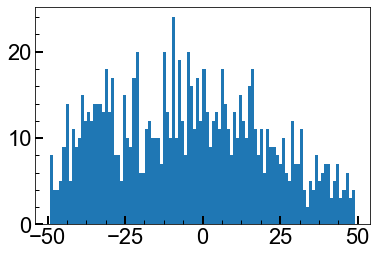

In [51]:
plt.hist(xvec_cap,100);

In [58]:
#Look at the direction they're coming from
er_df_full = pd.DataFrame(data=data_nocap_er, columns=cols)
print(er_df_full.agg({'PX1':'mean','PY1':'mean','PZ1':'mean','X3':'mean','Y3':'mean','Z3':'mean'}))

nr_df_full = pd.DataFrame(data=data_nr, columns=cols)
print(nr_df_full.agg({'PX1':'mean','PY1':'mean','PZ1':'mean','X3':'mean','Y3':'mean','Z3':'mean'}))

cap_df_full = pd.DataFrame(data=data_cap, columns=cols)
print(cap_df_full.agg({'PX1':'mean','PY1':'mean','PZ1':'mean','X3':'mean','Y3':'mean','Z3':'mean'}))

wcap_df_full = pd.DataFrame(data=data_wcap, columns=cols)
print(wcap_df_full.agg({'PX1':'mean','PY1':'mean','PZ1':'mean','X3':'mean','Y3':'mean','Z3':'mean'}))

PX1     0.002486
PY1    -0.001924
PZ1     0.004337
X3     -1.827668
Y3      1.620456
Z3     36.279429
dtype: float64
PX1     2.146512
PY1    -1.038616
PZ1     0.722932
X3     -3.193469
Y3      0.498850
Z3     36.714896
dtype: float64
PX1     0.770270
PY1    -1.596945
PZ1     0.989577
X3     -4.614729
Y3      0.586568
Z3     36.398143
dtype: float64
PX1     0.128569
PY1    -0.263233
PZ1     0.170434
X3     -2.994872
Y3      0.512552
Z3     36.653098
dtype: float64


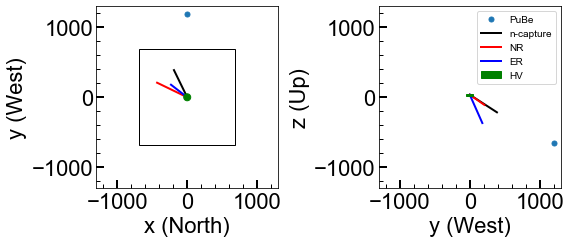

In [60]:
from matplotlib.patches import Rectangle
fig,axes = plt.subplots(1,2,figsize=(8.0,5.0),sharex=False)
rsource=[0.0, 1197.31, -646.79]#mm
rdet=[0,0,Z0]#mm
Lshield=54*25.4

flux_er=np.array([0.002486, -0.001924, 0.004337])
flux_er=500*flux_er/(np.sum([i**2 for i in flux_er]))**0.5
flux_nr=np.array([2.146512, -1.038616, 0.722932])
flux_nr=500*flux_nr/(np.sum([i**2 for i in flux_nr]))**0.5
flux_wcap=np.array([0.128569,-0.263233, 0.170434])
flux_wcap=500*flux_wcap/(np.sum([i**2 for i in flux_wcap]))**0.5

#y vs x
axes[0].plot(rsource[0],rsource[1],'o',markersize=5)
axes[0].add_artist(plt.Circle((rdet[0],rdet[1]), R, color='g'))
axes[0].add_patch(Rectangle((rdet[0]-Lshield/2,rdet[1]-Lshield/2),Lshield,Lshield,linewidth=1,edgecolor='k',facecolor='none'))

axes[0].plot([rdet[0],rdet[0]-flux_wcap[0]],[rdet[1],rdet[1]-flux_wcap[1]],color='k',linewidth=2,zorder=1)
axes[0].plot([rdet[0],rdet[0]-flux_nr[0]],[rdet[1],rdet[1]-flux_nr[1]],color='r',linewidth=2,zorder=1)
axes[0].plot([rdet[0],rdet[0]-flux_er[0]],[rdet[1],rdet[1]-flux_er[1]],color='b',linewidth=2,zorder=1)

axes[0].set_xlim(-1300,1300)
axes[0].set_ylim(-1300,1300)
axes[0].set_aspect('equal', adjustable='box')

axes[0].set_xlabel('x (North)')
axes[0].set_ylabel('y (West)')

# z vs y
axes[1].plot(rsource[1],rsource[2],'o',markersize=5,label="PuBe")
#axes[1].plot(rdet[1],rdet[2],'o',markersize=20)
axes[1].add_patch(Rectangle((rdet[1]-R,rdet[2]-Z/2),2*R,Z,linewidth=1,edgecolor='g',facecolor='g',zorder=2,label="HV"))

axes[1].plot([rdet[1],rdet[1]-flux_wcap[1]],[rdet[2],rdet[2]-flux_wcap[2]],color='k',linewidth=2,zorder=1,label='n-capture')
axes[1].plot([rdet[1],rdet[1]-flux_nr[1]],[rdet[2],rdet[2]-flux_nr[2]],color='r',linewidth=2,zorder=1,label='NR')
axes[1].plot([rdet[1],rdet[1]-flux_er[1]],[rdet[2],rdet[2]-flux_er[2]],color='b',linewidth=2,zorder=1,label='ER')

axes[1].set_xlim(-1300,1300)
axes[1].set_ylim(-1300,1300)
axes[1].set_aspect('equal', adjustable='box')

axes[1].set_xlabel('y (West)')
axes[1].set_ylabel('z (Up)')
axes[1].legend()

plt.tight_layout()
if savePlots:
    plt.savefig('figures/R68_sim_gdirect_P1_directions.png')
plt.show()


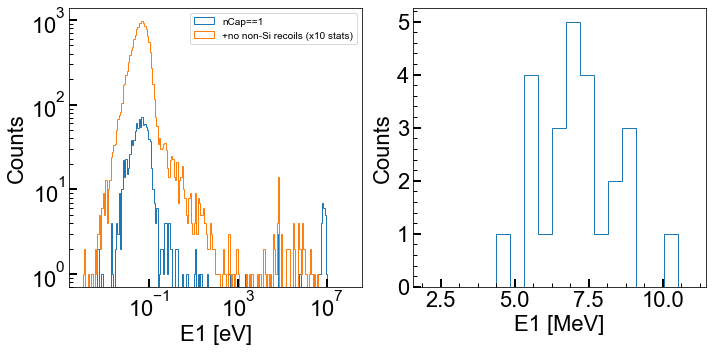

In [64]:
#Incoming capture n energies
e1_cap = list()

cap_grouped2=cap_dataframe.groupby('EV').agg({'E1':list})
for e1 in cap_grouped2.E1:
    #print(e1.shape())
    e1_cap.append(e1[0]*1e6) #convert from MeV
e1_cap=np.array(e1_cap)

fig,axes = plt.subplots(1,2,figsize=(10.0,5.0),sharex=False)

axes[0].hist(e1_cap,np.logspace(-4,8,200),histtype='step',label='nCap==1');
axes[0].hist(e1vec_wcap,np.logspace(-4,8,200),histtype='step',label='+no non-Si recoils (x10 stats)');
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('E1 [eV]')
axes[0].set_ylabel('Counts')
axes[0].legend()

axes[1].hist(e1_cap/1e6,np.linspace(2,11,20),histtype='step');
axes[1].set_xscale('linear')
axes[1].set_yscale('linear')
axes[1].set_xlabel('E1 [MeV]')
axes[1].set_ylabel('Counts')

plt.tight_layout()
if savePlots:
    plt.savefig('figures/R68_sim_gdirect_E1_cap.png')
plt.show()

In [55]:
len(e1vec_wcap)

14182

In [56]:
wcap_dataframe.groupby(['Type']).agg({'E1':list,'Type':list})

,E1,Type
Type,,
-12.0,"[0.2926356936, 1.172764946, 0.6826004316, 1.89...","[-12.0, -12.0, -12.0, -12.0, -12.0, -12.0, -12..."
-11.0,"[4.192297013, 2.978858464, 2.129715643, 1.4162...","[-11.0, -11.0, -11.0, -11.0, -11.0, -11.0, -11..."
11.0,"[0.02147523426, 1.198845948, 0.6052756584, 0.1...","[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11...."
22.0,"[2.092897502, 2.071422268, 2.425702781, 5.1067...","[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22...."
2112.0,"[9.380187294e-09, 5.019865057e-08, 5.527363101...","[2112.0, 2112.0, 2112.0, 2112.0, 2112.0, 2112...."
2212.0,"[0.3874452915, 2.973588885, 0.07713989663, 0.0...","[2212.0, 2212.0, 2212.0, 2212.0, 2212.0, 2212...."
4002.0,"[2.494779831, 2.385733114, 3.454027109, 0.1468...","[4002.0, 4002.0, 4002.0, 4002.0, 4002.0, 4002...."
25012.0,"[0.3901120292, 0.0, 0.8355774821, 0.0, 1.41163...","[25012.0, 25012.0, 25012.0, 25012.0, 25012.0, ..."
26012.0,"[0.3339010255, 0.0, 0.172541731, 0.0, 2.242364...","[26012.0, 26012.0, 26012.0, 26012.0, 26012.0, ..."


In [57]:
wcap_dataframe[wcap_dataframe['E1']==np.sort(e1vec_wcap,axis=None)[-2]/1e6]

,EVnew,EV,Type,E1,D3,X3,Y3,Z3,PX1,PY1,PZ1,nCap
88832,7807.0,8031708.0,2112.0,3.100135,0.0,5.623786,-26.134451,39.569931,-5.232522,18.546913,73.917543,1.0
